# Partie 0 : Quelques imports de bon fonctionnement

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import random as rd

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

In [39]:
import csv

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [40]:
def convert_to_one_hot(vecteur):
    n_values = int(np.max(vecteur) + 1)
    oh = np.eye(n_values)[vecteur]
    return oh

In [41]:
data = pd.read_csv("/content/drive/My Drive/Wine_project/winemag-data-130k-v2.csv")

In [42]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/My Drive/Wine_project/glove.6B.50d.txt')

# Partie 1: Statistiques descriptives

In [43]:
data = data.drop('Unnamed: 0', axis = 1)
data.columns


Index(['country', 'description', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'title',
       'variety', 'winery'],
      dtype='object')

In [44]:
data['country'].nunique()
data['region_2'].nunique()
data['province'].count()

129908

In [45]:
data.describe()

,points,price
count,129971.000000,120975.000000
mean,88.447138,35.363389
std,3.039730,41.022218
min,80.000000,4.000000
25%,86.000000,17.000000
50%,88.000000,25.000000
75%,91.000000,42.000000
max,100.000000,3300.000000


In [46]:
data.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

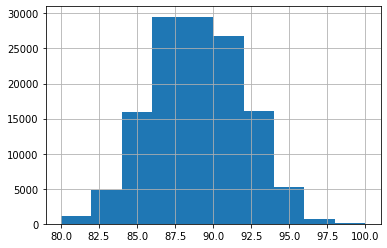

In [47]:
fig = data['points'].hist()
plt.show()

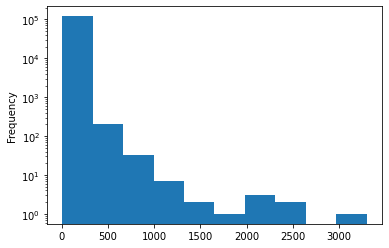

In [48]:
fig = data['price'].plot(kind = 'hist', logy=True)
plt.show()

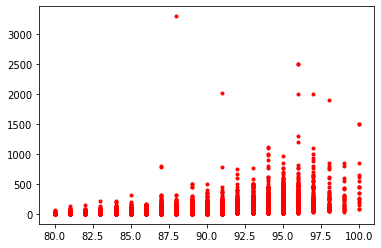

In [49]:
plt.plot(data['points'], data['price'], 'r.')

In [50]:
priceForPoint = data.groupby(by="points").mean()

In [51]:
#PriceForPoint donne la moyenne du prix de la bouteille pour un nbr de point donné

[]

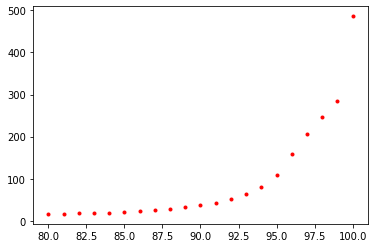

In [52]:
plt.plot(priceForPoint.index, priceForPoint , 'r.')
plt.plot()

[]

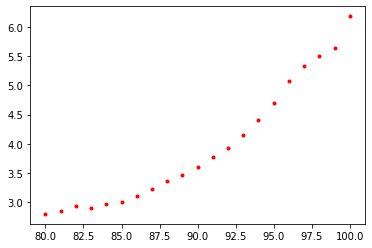

In [53]:
plt.plot(priceForPoint.index, np.log(priceForPoint) , 'r.')
plt.plot()

In [54]:
countries = data[ ["country", "winery"] ].groupby(by="country").count().sort_values(by="winery")[::-1]
countries.count()

winery    43
dtype: int64

In [55]:
countries_price = data[ ["country", "price"]].groupby(by ="country").mean()

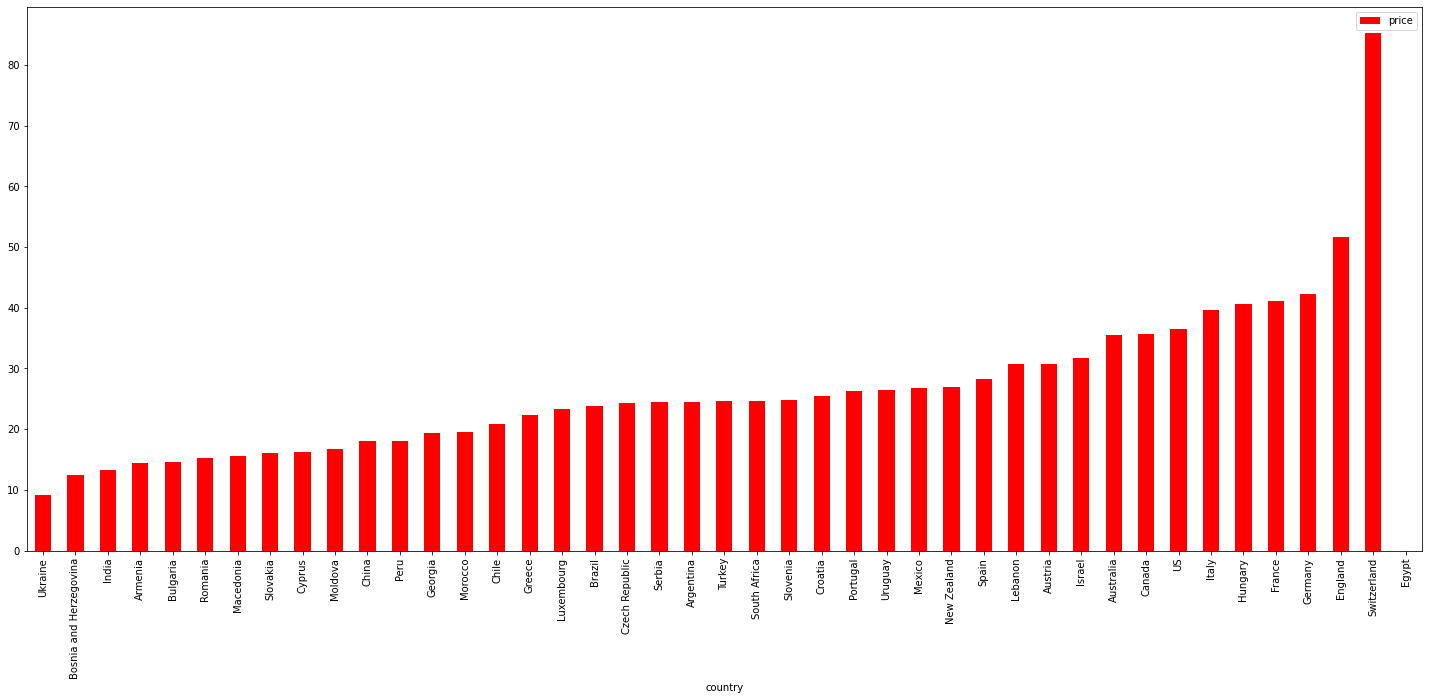

In [56]:
countries_price.sort_values('price').plot(kind = "bar", figsize = (25,10), color = 'red')

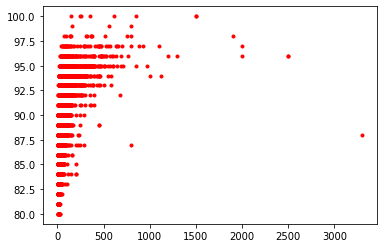

In [57]:
dfr=data[data["country"] == 'France']
plt.plot(dfr['price'],dfr['points'], 'r.')

In [58]:
dfr_max=dfr[dfr['price']> dfr['price'].quantile( q = 0.99)]

In [59]:
dfr_max=dfr_max[['region_1','winery']]

In [60]:
dfr_max.count()

region_1    172
winery      172
dtype: int64

In [61]:
dfr_max_winery = dfr_max.groupby('region_1').count().sort_values(by="winery")[::-1]
dfr_max_winery.head()

,winery
region_1,
Champagne,22
Pessac-Léognan,13
Pauillac,12
Chevalier-Montrachet,11
Bâtard-Montrachet,10


# Partie 2 : Premier Modèle

## Modèle 1.1

In [62]:
data_10000 = data.sample(frac = 0.1, random_state = 1)
X = data_10000['description']
Y = data_10000['points']

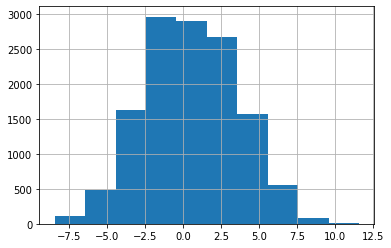

In [63]:
Y_corr= Y-Y.mean()
fig = Y_corr.hist()
plt.show()

In [64]:
#On va essayer de prédire, en fonction de la description, un score en séparant en 5 parties qui sera ensuite ramené sur 100.

In [65]:
groupe = (max(Y_corr)-min(Y_corr))/5
print("on va faire 5 catégories de taille", groupe+0.001)

on va faire 5 catégories de taille 4.001


In [66]:
Y_corr = np.array(Y_corr)
X = np.array(X)
mini = min(Y_corr)
for idx in range(len(Y_corr)):
    Y_corr[idx] = abs(Y_corr[idx] - mini)//4.001   

In [67]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)
Y_train = np.array(Y_train, dtype = int)

In [68]:
def sentence_to_avg(sentence, word_to_vec_map):
 
    # Step 1: Split sentence into list of lower case words (≈ 1 line)
    words = sentence.lower().split()

    # Initialize the average word vector, should have the same shape as your word vectors.
    avg = np.zeros(50)
    
    # Step 2: average the word vectors. You can loop over the words in the list "words".
    total = 0
    for w in words:
        while w not in word_to_vec_map.keys():
            if w[1:] in word_to_vec_map.keys():
                w = w[1:]
            else:
                w = w[:-1]
        total += word_to_vec_map[w]
    avg = total/len(words)
    
    ### END CODE HERE ###
    
    return avg

In [69]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()


def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 400):

    m = Y.shape[0]                          # number of training examples
    n_y = 5                                 # number of classes  
    n_h = 50                                # dimensions of the GloVe vectors 
    
    # Initialize parameters using Xavier initialization
    W = np.random.randn(n_y, n_h) / np.sqrt(n_h)
    b = np.zeros((n_y,)) 
    
    # Convert Y to Y_onehot with n_y classes
    Y_oh = convert_to_one_hot(Y) 
    
    # Optimization loop
    for t in range(num_iterations): # Loop over the number of iterations
        for i in range(m):          # Loop over the training examples
            
            # Average the word vectors of the words from the i'th training example
            avg = sentence_to_avg(X[i], word_to_vec_map)

            # Forward propagate the avg through the softmax layer
            z = np.dot(W,avg) + b
            a = softmax(z)

            # Compute cost using the i'th training label's one hot representation and "A" (the output of the softmax)
            cost = - np.sum(Y_oh*np.log(a))
            
            # Compute gradients 
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1), avg.reshape(1, n_h))
            db = dz

            # Update parameters with Stochastic Gradient Descent
            W = W - learning_rate * dW
            b = b - learning_rate * db
        
        if t % 100 == 0:
            print("Epoch: " + str(t) + " --- cost = " + str(cost))
            pred = predict(X, Y, W, b, word_to_vec_map)

    return pred, W, b

In [70]:
def predict(X, Y, W, b, word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    m = X.shape[0]
    pred = np.zeros((m, 1))
    
    for j in range(m):                       # Loop over training examples
        
        # Split jth test example (sentence) into list of lower case words
        words = X[j].lower().split()
        
        # Average words' vectors
        avg = np.zeros((50,))
        for w in words:
            while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            avg += word_to_vec_map[w]
        avg = avg/len(words)

        # Forward propagation
        Z = np.dot(W, avg) + b
        A = softmax(Z)
        pred[j] = np.argmax(A)
        
    print("Accuracy: "  + str(np.mean((pred[:] == Y.reshape(Y.shape[0],1)[:]))))
    
    return pred

In [71]:
pred, W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

[[0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
Epoch: 0 --- cost = 14714.092665361983
Accuracy: 0.48475521785130327
Epoch: 100 --- cost = 27607.80042435002
Accuracy: 0.5486197941713956
Epoch: 200 --- cost = 27913.87658920504
Accuracy: 0.5500625180340483
Epoch: 300 --- cost = 27944.22408697108
Accuracy: 0.5503510628065789
[[2.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [72]:
print("Training set:")
pred_train = predict(X_train, Y_train, W, b, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W, b, word_to_vec_map)

Training set:
Accuracy: 0.5500625180340483
Test set:
Accuracy: 0.5423076923076923


In [73]:
#On se retrouve avec une accuracy de 50... ce qui est mieux que le hasard (5 catégories) mais pas encore optimal
#On va utiliser un algo de LTSM pour pouvoir cette fois ci prendre en compte l'ordre des éléments dans la phrase

In [74]:
#Quelques test
idx = rd.randint(0,len(X))
X[idx],Y_corr[idx], idx

("Light strawberry fruit with tart acidity carries a wine of modest proportions. It's drinking well, and might be a good choice for a simple salmon preparation, as it would not overwhelm the fish. The finishing tannins have a definite herbal flavor.",
 1.0,
 6767)

In [75]:
X_my_sentences = np.array(["I love that wine, it is so tasteful. A great success to see in the future"])
Y_my_labels = np.array([[3]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 1.0


array([[3.]])

In [76]:
X_my_sentences = np.array(["I love that wine , it is so tasteful. A great success ! Tasteful love so good"])
Y_my_labels = np.array([[4]])
pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
pred

Accuracy: 0.0


array([[3.]])

In [77]:
#Regardons à partir d'une matrice de confusion ce qui pose problème

In [78]:
def plot_confusion_matrix(y_actu, y_pred, title='Confusion matrix', cmap=plt.cm.gray_r):
    
    df_confusion = pd.crosstab(y_actu, y_pred.reshape(y_pred.shape[0],), rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    df_conf_norm = df_confusion / df_confusion.sum(axis=1)
    
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

Predicted  0.0   1.0   2.0  3.0   All
Actual                               
0.0         53   170    32    0   255
1.0         25   822   297    5  1149
2.0          4   399   520   21   944
3.0          0    50   178   15   243
4.0          0     1     7    1     9
All         82  1442  1034   42  2600


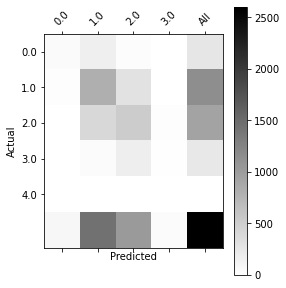

In [79]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [80]:
#Problème : pas assez de '4' pour que l'algo le prédise..., les classes sont trop centrées sur 3 et 4. Il nous faut une refonte des groupes.

## Modèle 1.2

In [81]:
quant = Y.quantile([0.2,0.4,0.6,0.8,1])

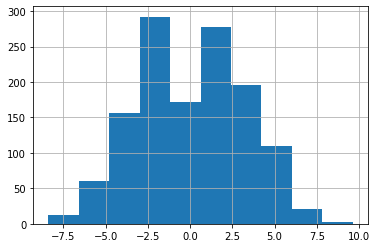

In [82]:
data_1000 = data.sample(frac = 0.01, random_state = 1)
X = data_1000['description']
Y = data_1000['points']

Y_corr= Y-Y.mean()
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

Y_corr = np.array(Y_corr)
for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2]:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4]:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6]:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8]:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4

In [83]:
X = np.array(X)
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y_corr,test_size=0.2)


In [84]:
pred, W_1, b_1 = model(X_train, Y_train, word_to_vec_map)
print(pred)

[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]]
Epoch: 0 --- cost = 1615.1540526841693
Accuracy: 0.2875
Epoch: 100 --- cost = 2007.6479221978036
Accuracy: 0.45
Epoch: 200 --- cost = 2127.49035576192
Accuracy: 0.46442307692307694
Epoch: 300 --- cost = 2172.991099634395
Accuracy: 0.4653846153846154
[[3.]
 [0.]
 [0.]
 ...
 [0.]
 [4.]
 [4.]]


In [85]:
print("Training set:")
pred_train = predict(X_train, Y_train, W_1, b_1, word_to_vec_map)
print('Test set:')
pred_test = predict(X_test, Y_test, W_1, b_1, word_to_vec_map)


Training set:
Accuracy: 0.46153846153846156
Test set:
Accuracy: 0.36923076923076925


Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0           49   12    1    0    6   68
1           37   11    1    5   11   65
2           15    9    3    4    5   36
3           14    5    1    9   19   48
4            7    3    0    9   24   43
All        122   40    6   27   65  260


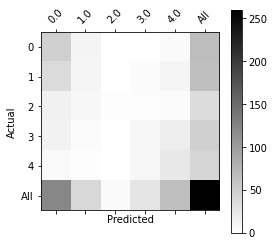

In [88]:
print(pd.crosstab(Y_test, pred_test.reshape(Y_test.shape), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)

In [89]:
#Mieux que le hasard certes mais toujours pas fou, on va tenter le LSTM

# Partie 3 : Modèle LSTM

In [90]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform

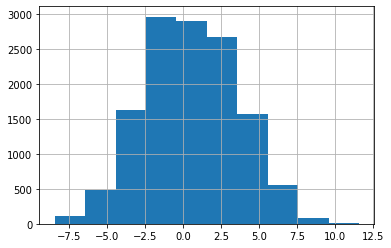

In [91]:
data_10000 = data.sample(frac = 0.1, random_state = 1)
X_LTSM = data_10000['description']
Y = data_10000['points']
Y_corr= (Y-Y.mean())
quant = Y.quantile([0.2,0.4,0.6,0.8,1])
quant = quant - Y.mean()
fig = Y_corr.hist()
plt.show()

X_LTSM = np.array(X_LTSM)
Y_corr = np.array(Y_corr)

maxLen = 0
for i in range(len(X_LTSM)):
    if maxLen < len(X_LTSM[i].split()):
      maxLen = len(X_LTSM[i])

for idx in range(len(Y_corr)):
    if Y_corr[idx] <= quant[0.2]:
        Y_corr[idx] = 0
    elif Y_corr[idx] <= quant[0.4]:
        Y_corr[idx] = 1
    elif Y_corr[idx] <= quant[0.6]:
        Y_corr[idx] = 2
    elif Y_corr[idx] <= quant[0.8]:
        Y_corr[idx] = 3
    else:
        Y_corr[idx] = 4


In [92]:
maxLen

250

In [93]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))
    
    for i in range(m):                               # loop over training examples
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = X[i].lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
          while w not in word_to_vec_map.keys():
                if w[1:] in word_to_vec_map.keys():
                    w = w[1:]
                else:
                    w = w[:-1]
            # Set the (i,j)th entry of X_indices to the index of the correct word.
          X_indices[i, j] = word_to_index[w]
          j += 1
            
    
    return X_indices

In [94]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(word_to_index) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    # Step 3
    # Define Keras embedding layer with the correct input and output sizes
    # Make it non-trainable.
    embedding_layer = Embedding(vocab_len, emb_dim )
    ### END CODE HERE ###

    # Step 4 (already done for you; please do not modify)
    # Build the embedding layer, it is required before setting the weights of the embedding layer. 
    embedding_layer.build((None,)) # Do not modify the "None".  This line of code is complete as-is.
    
    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])
    
    return embedding_layer

In [95]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
print("weights[0][1][3] =", embedding_layer.get_weights()[0][1][3])

weights[0][1][3] = -0.3403


In [96]:
def Emojify_V2(input_shape, word_to_vec_map, word_to_index):
    """
    Function creating the Emojify-v2 model's graph.
    
    Arguments:
    input_shape -- shape of the input, usually (max_len,)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    model -- a model instance in Keras
    """
    
    # Define sentence_indices as the input of the graph.
    # It should be of shape input_shape and dtype 'int32' (as it contains indices, which are integers).
    sentence_indices = Input(input_shape, dtype= 'int32')
    
    # Create the embedding layer pretrained with GloVe Vectors (≈1 line)
    embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
    
    # Propagate sentence_indices through your embedding layer
    # (See additional hints in the instructions).
    embeddings = embedding_layer(sentence_indices)
    
    # Propagate the embeddings through an LSTM layer with 128-dimensional hidden state
    # The returned output should be a batch of sequences.
    X = LSTM(128, return_sequences=True)(embeddings)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X trough another LSTM layer with 128-dimensional hidden state
    # The returned output should be a single hidden state, not a batch of sequences.
    X = LSTM(128, return_sequences=False)(X)
    # Add dropout with a probability of 0.5
    X = Dropout(0.5)(X)
    # Propagate X through a Dense layer with 5 units
    X = Dense( units = 5)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices, outputs=X)
    
    ### END CODE HERE ###
    
    return model

In [97]:
model = Emojify_V2((maxLen,), word_to_vec_map, word_to_index)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 250, 50)           20000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 250, 128)          91648     
_________________________________________________________________
dropout_2 (Dropout)          (None, 250, 128)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

In [98]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
Y_corr = np.array(Y_corr, dtype=int)
X_train,X_test,Y_train,Y_test=train_test_split(X_LTSM,Y_corr,test_size=0.2)

In [100]:
X_train_indices = sentences_to_indices(X_train, word_to_index, maxLen)
Y_train_oh = convert_to_one_hot(Y_train)

In [101]:
model.fit(X_train_indices, Y_train_oh, epochs = 5, batch_size = 500, shuffle=True)

Epoch 1/5
21/21 [==============================] - 86s 4s/step - loss: 1.5714 - accuracy: 0.2631
Epoch 2/5
21/21 [==============================] - 85s 4s/step - loss: 1.5577 - accuracy: 0.2591
Epoch 3/5
21/21 [==============================] - 85s 4s/step - loss: 1.5564 - accuracy: 0.2693
Epoch 4/5
21/21 [==============================] - 85s 4s/step - loss: 1.5570 - accuracy: 0.2702
Epoch 5/5
21/21 [==============================] - 85s 4s/step - loss: 1.5566 - accuracy: 0.2607


In [103]:
X_test_indices = sentences_to_indices(X_test, word_to_index, max_len = maxLen)
Y_test_oh = convert_to_one_hot(Y_test)
loss, acc = model.evaluate(X_test_indices, Y_test_oh)
print()
print("Test accuracy = ", acc)

82/82 [==============================] - 9s 110ms/step - loss: 1.5491 - accuracy: 0.2677

Test accuracy =  0.26769229769706726


In [107]:
W_1

array([[-1.70781508, -1.96719664,  1.2208899 , -0.37385762, -0.46646685,
        -0.96836427, -1.86910213, -0.87952319,  0.19868038,  0.8411556 ,
        -0.54483936,  0.01256654, -0.18018675, -1.13896316,  0.0335442 ,
         1.98223387, -2.67815518, -1.66261002,  0.16936117, -2.36422392,
        -3.57809728, -0.60557339,  1.88912146,  1.49206241,  1.44728134,
        -0.97291236,  0.47305511,  1.42748015,  1.9818897 ,  1.47056577,
         1.17367755, -1.3143886 ,  0.0801245 ,  1.04331089,  4.38620277,
        -1.66540654,  2.08708418, -1.43541932,  1.50929435,  3.54914627,
        -0.59194744,  1.22113328, -2.28061653,  0.21070292,  2.48314664,
         1.07986298,  0.246817  ,  1.97342762,  3.70281023,  1.42718281],
       [-0.80524984, -0.92985527, -1.28044816, -0.71426552, -0.71652517,
        -1.40272439,  1.12747378, -1.65869306, -1.0416431 , -1.03561788,
         0.53251278, -1.00062289,  1.98467804, -0.06321153, -1.24151576,
        -0.26269694,  0.70386007,  1.39953882,  0.